# Notebook Objective and Setup

BGG05 is the building of a content-based item filter. Using category weights, I use my domain expertise to tune an item similarity matrix for all game IDs in the games file.

This content-based filter could be used as-is to find similar games to a user's catalog and predict ratings.

## Notebook Preparation

### Package Imports

In [46]:
import pandas as pd
import numpy as np
import requests
import regex as re
import time
import os
import gc
import copy
import json

# ignore warnings (gets rid of Pandas copy warnings)
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from missingpy import MissForest
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer

import umap
import umap.plot
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
%matplotlib inline

### Notebook Functions

##### Processing Functions

In [3]:
def processing_pipeline(weight_groups, df):
    '''
    Hard-coded processor!
    Takes in weight tuples and a dataframe
    Scales specific dataframe columns to tuples
    
    Inputs:
    weight_groups: list of weight tuples (x, y)
    df: df to be scaled
    
    Returns:
    Processed Dataframe'''

   
    # continuous pipeline
    family_encoder = Pipeline([
        ('encoder', OneHotEncoder()),
        ('scaler', MinMaxScaler(feature_range=weight_groups[5])),
         ])
    
    # Whole pipeline with continuous then categorical transformers
    total_pipeline = ColumnTransformer([
        ('games_weight_weight', MinMaxScaler(feature_range=weight_groups[0]), ['GameWeight']),
        ('bayes_weight', MinMaxScaler(feature_range=weight_groups[1]), ['BayesAvgRating']),  
        ('players_weight', MinMaxScaler(feature_range=weight_groups[2]), ['BestPlayers']),
        ('playtime_weight', MinMaxScaler(feature_range=weight_groups[3]), ['Playtime']),
        ('remainder_weight', MinMaxScaler(feature_range=weight_groups[4]), [ 'Cat:War',
                       'Cat:CGS','Cat:Abstract','Cat:Party','Cat:Childrens']),
                            ]) 
    
    # Fit and tranform the pipeline on x_train, then transform x_test
    processed = total_pipeline.fit_transform(df)
    
    return processed

In [4]:
def scale_dataset(dataset, weights, tfidf=False):
    '''
    Set each item either according to Term Frequency or TF-IDF
    Then scale dataset according to provided weights
    
    tfidf flag:
    Use TRUE when RARE entries are more important than FREQUENT entries
    Use FALSE when COMMON entries are more important than RARE entries
    
    Inputs:
    dataset: dataset to scale
    weights: tuple (x, y) to weight dataset
    tfidf: set flag to True for TF-IDF
    
    Outputs:
    Scaled data
    '''
    
    # drop BGG Id
    try: 
        dataset_pared = dataset.drop('BGGId', axis=1)
    except: 
        dataset_pared = dataset
    
    # get list of titles to reapply to DF after transformation
    titles = list(dataset_pared.columns)

    # set up weighted scaler
    scaler = MinMaxScaler(feature_range = weights)
    
    # get total number of entries
    total_entries = sum(dataset.sum())
    
    if tfidf:
        
        #instantiate tfidf transformer
        tfidf = TfidfTransformer()
    
        #convert matrix to tfidf 
        tfidf_dataset = pd.DataFrame(tfidf.fit_transform(dataset_pared).toarray(), columns=titles)
        
        # run scaler on transpose (scale by row not column)
        transpose_scaled = scaler.fit_transform(tfidf_dataset.T)
        
    else:
        # for each column,
        for item in list(dataset_pared.columns):
            # set item as its term frequency
            dataset_pared.loc[dataset_pared[item]>0, item] = dataset_pared[item].sum()/total_entries
    
        # run scaler on transpose (scale by row not column)
        transpose_scaled = scaler.fit_transform(dataset_pared.T)
    
    # rebuild dataframe
    scaled_dataset = pd.DataFrame(transpose_scaled.T, columns=titles)
    
    return scaled_dataset


# Content Based Filtering

## Set Weights

These are the scales for each of these categories. All entries in the category will be scaled to this tuple range by the MinMaxScaler.

In [5]:
games_weight_weight = (-1.5, 1.5) # game weight. Is a range, so (-, )
bayes_weight = (-.5, .5) # game weighted rating. Is a range, so (-, )
players_weight = (0, .5) # best players. Is a problematic range due to outliers
playtime_weight = (0, 1.5) # playtime. Is a range so (-, ). Has high outliers
designers_weight = (0, 0.3) # designers, binary
mechanics_weight = (0, .5) # mechanics, binary
subcategories_weight = (0, 0.5) # other mechanics like card game, print&play. binary
family_weights = (0, 0.2) # game families like pandemic, century. binary
categories_weight = (0, 0.5) # the five large overarching categories, binary
themes_weight = (-.001, 0.001) # themes like space, western. binary

## Load and Prep Data

In [6]:
# Load games
games = pd.read_pickle('data_cleaned/games.pkl')

# determine playtime for each game according to community
games['Playtime'] = 0
games['Playtime'] = games.apply(lambda x: np.mean(x['ComMinPlaytime'] + x['ComMaxPlaytime']), axis=1)

# set upper cap on playtime
over_6_hours = list(games.loc[games['Playtime']>360].index)
games.loc[over_6_hours, 'Playtime']=360

# load other files to use
mechanics = pd.read_pickle('data_cleaned/mechanics.pkl')
designers = pd.read_pickle('data_cleaned/designers_reduced.pkl')
subcategories = pd.read_pickle('data_cleaned/subcategories.pkl')
themes = pd.read_pickle('data_cleaned/themes.pkl')

games.head()

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,LanguageEase,BestPlayers,GoodPlayers,NumOwned,NumWant,NumWish,NumWeightVotes,MfgPlaytime,ComMinPlaytime,ComMaxPlaytime,MfgAgeRec,NumUserRatings,NumComments,NumAlternates,NumExpansions,NumAwards,NumImplementations,NumFans,NumPageViews,RulesPosts,TotalPosts,IsExpansion,IsReimplementation,Family,Theme,Category,Kickstarted,ImagePath,Rank:boardgame,Rank:thematic,Rank:strategygames,Rank:wargames,Rank:familygames,Rank:cgs,Rank:abstracts,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,Playtime
0,174430,Gloomhaven,gloomhaven game euroinspired tactical combat...,2017,3.8726,8.76029,8.52385,1.63358,1,4,12.784946,4.152542,3,"[1, 2, 3, 4]",74975,1375,17276,2009,120,60,120,14,46228,8308,6,12,30,0,7718,10816029,6326,14752,0,0,Gloomhaven,NaN,Dungeon Crawl,1,https://cf.geekdo-images.com/sZYp_3BTDGjh2unaZ...,1,1,1,21369,21369,21369,21369,21369,21369,1,1,0,0,0,0,0,0,180.0
1,161936,Pandemic Legacy: Season 1,pandemic legacy cooperative campaign game over...,2015,2.8331,8.60116,8.45000,1.56368,2,4,11.354037,4.077778,4,"[2, 3, 4]",68974,840,11544,1210,60,60,60,13,44043,6682,10,0,30,2,2952,3450336,1229,3086,0,1,Pandemic,NaN,NaN,0,https://cf.geekdo-images.com/-Qer2BBPG7qGGDu6K...,2,2,3,21369,21369,21369,21369,21369,21369,1,1,0,0,0,0,0,0,120.0
2,224517,Brass: Birmingham,brass birmingham economic strategy game sequel...,2018,3.9038,8.66907,8.41066,1.24331,2,4,13.226190,1.035714,3,"[2, 3, 4]",35448,1528,11277,1143,120,60,120,14,23776,3610,6,0,18,1,1902,1974872,387,1028,0,1,Brass,Canals,NaN,1,https://cf.geekdo-images.com/x3zxjr-Vw5iU4yDPg...,3,21369,2,21369,21369,21369,21369,21369,21369,0,1,0,0,0,0,0,0,180.0
3,167791,Terraforming Mars,s mankind begin terraform planet mar giant cor...,2016,3.2429,8.42155,8.27751,1.38628,1,5,11.891156,3.380952,3,"[1, 2, 3, 4]",97330,2061,18842,2944,120,120,120,12,71474,10452,14,22,39,2,6372,6285054,1155,4313,0,0,Terraforming Mars,NaN,NaN,0,https://cf.geekdo-images.com/wg9oOLcsKvDesSUdZ...,4,21369,6,21369,21369,21369,21369,21369,21369,0,1,0,0,0,0,0,0,240.0
4,291457,Gloomhaven: Jaws of the Lion,gloomhaven jaw lion standalone game take place...,2020,3.5649,8.72198,8.25902,1.42169,1,4,12.051948,4.000000,2,"[1, 2, 3, 4]",33444,477,6250,485,120,30,120,14,13939,2149,6,0,11,0,1649,1471587,1073,2062,0,0,Gloomhaven,NaN,Dungeon Crawl,0,https://cf.geekdo-images.com/_HhIdavYW-hid20Iq...,5,3,5,21369,21369,21369,21369,21369,21369,1,1,0,0,0,0,0,0,150.0


### Weight Scale Datasets

##### TF-IDF Mechanics

In [7]:
# get floor of mechanics presence in catalog (.05% of games)
mechanics_floor = round(mechanics.shape[0]*.005)

# make a list of mechanics more than the floor
sums = pd.DataFrame(mechanics.sum()>=mechanics_floor)

# get indices for the mechanics keeping
keep_mechanics = sums.loc[sums[0]==True].index

refined_mechanics = mechanics[keep_mechanics]

# scaled mechanics
scaled_mechanics = scale_dataset(refined_mechanics, mechanics_weight, tfidf=True)

# make new column for games without any mechanics information
no_mechanics_index = list(scaled_mechanics.loc[scaled_mechanics.sum(axis=1)==0].index)
scaled_mechanics['No Mechanics'] = 0
scaled_mechanics.loc[no_mechanics_index, 'No Mechanics'] = (mechanics_weight[1])

##### TF-Scale Only Datasets

In [8]:
# scale themes
scaler = MinMaxScaler(feature_range=themes_weight)
scaled_themes = scaler.fit_transform(themes)

# get list of titles to reapply to DF after transformation
titles = list(themes.columns)  

scaled_themes = pd.DataFrame(scaled_themes, columns=titles).drop('BGGId', axis=1, inplace=True)

# scaled designers
scaled_designers = scale_dataset(designers, designers_weight)

# scaled game families
game_families = pd.get_dummies(games['Family'])
scaled_families = scale_dataset(game_families, family_weights)

#scaled subcategories
scaled_subcategories = scale_dataset(subcategories, subcategories_weight)

### Master CBF Frame

In [9]:
# include these columns for comparison
games_included_columns = ['GameWeight', 'BayesAvgRating', 'BestPlayers', 'Playtime', 'Cat:War', 'Cat:CGS', 'Cat:Abstract', 'Cat:Party', 'Cat:Childrens'] 

# make smaller df of the included columns
scaled_games = games[games_included_columns]

# get list of game names
game_names = list(games['Name'])
# get list of game ids
game_ids = list(games['BGGId'])

# create game lookup table
game_lookup = {}
for key, value in zip(game_ids, game_names):
    game_lookup[key] = value

# instantiate MissForest imputer and fill all nans in scaled_games
imputer = MissForest()
scaled_games = pd.DataFrame(imputer.fit_transform(scaled_games), columns=games_included_columns)

In [10]:
# set up weight groups for hard coded pipeline
weight_groups = [games_weight_weight, bayes_weight, players_weight, playtime_weight, categories_weight, family_weights]

# process scaled_games with pipeline
scaled_games = pd.DataFrame(processing_pipeline(weight_groups, scaled_games), columns=games_included_columns)

# put together master dataframe with other already processed dataframes
master_games = pd.concat((scaled_games, scaled_mechanics, scaled_families, scaled_designers, scaled_subcategories), axis=1) #, scaled_themes

# make list of games and ids (is this used anywhere?)
game_and_id = list(zip(game_names, game_ids))

# put game id on master_games DF
master_games['BGGId'] = game_ids

# set index to id
master_games.set_index('BGGId', inplace=True)

master_games.head()

GameWeight  BayesAvgRating  BestPlayers  Playtime  Cat:War  Cat:CGS  \
BGGId                                                                         
174430     0.82356        0.500000     0.100000     0.750      0.0      0.0   
161936     0.19986        0.485087     0.133333     0.500      0.0      0.0   
224517     0.84228        0.477143     0.100000     0.750      0.0      0.0   
167791     0.44574        0.450256     0.100000     1.000      0.0      0.0   
291457     0.63894        0.446522     0.066667     0.625      0.0      0.0   

        Cat:Abstract  Cat:Party  Cat:Childrens  Action Queue  \
BGGId                                                          
174430           0.0        0.0            0.0       0.39878   
161936           0.0        0.0            0.0       0.00000   
224517           0.0        0.0            0.0       0.00000   
167791           0.0        0.0            0.0       0.00000   
291457           0.0        0.0            0.0       0.39878   

        Campaign / Battle Card Driven  Communication Limits  Cooperative Game  \
BGGId                                                                           
174430                       0.373871                   0.5          0.293568   
161936                       0.000000                   0.0          0.401750   
224517                       0.000000                   0.0          0.000000   
167791                       0.000000                   0.0          0.000000   
291457                       0.373871                   0.5          0.293568   

        Deck, Bag, and Pool Building  Grid Movement  Hand Management  \
BGGId                                                                  
174430                      0.350645       0.289155         0.208715   
161936                      0.000000       0.000000         0.285627   
224517                      0.000000       0.000000         0.252837   
167791                      0.000000       0.000000         0.220341   
291457                      0.000000       0.289155         0.208715   

        Hexagon Grid  Modular Board  Scenario / Mission / Campaign Game  \
BGGId                                                                     
174430      0.257114       0.285937                            0.385366   
161936      0.000000       0.000000                            0.000000   
224517      0.000000       0.000000                            0.000000   
167791      0.271437       0.000000                            0.000000   
291457      0.257114       0.000000                            0.385366   

        Simultaneous Action Selection  Solo / Solitaire Game  Storytelling  \
BGGId                                                                        
174430                       0.315171               0.339237        0.3857   
161936                       0.000000               0.000000        0.0000   
224517                       0.000000               0.000000        0.0000   
167791                       0.000000               0.358134        0.0000   
291457                       0.315171               0.339237        0.0000   

        Variable Player Powers  Action Points  Point to Point Movement  \
BGGId                                                                    
174430                0.248530       0.000000                 0.000000   
161936                0.340114       0.433825                 0.457381   
224517                0.000000       0.000000                 0.000000   
167791                0.262374       0.000000                 0.000000   
291457                0.248530       0.000000                 0.000000   

        Set Collection  Trading  Network and Route Building  Variable Set-up  \
BGGId                                                                          
174430        0.000000      0.0                    0.000000              0.0   
161936        0.330757      0.5                    0.000000              0.0   
224517        0.0000

In [11]:
# clean up

del mechanics
del designers
del subcategories
del themes
del scaled_mechanics
del scaled_families
del scaled_designers
del scaled_games
del scaled_subcategories
del scaled_themes

gc.collect()

1546

## Item Similarity via Cosine Distance

In [12]:
# get cosine similarities!
cosine_sims = cosine_similarity(master_games)

# do similarities by name
sims_byname = pd.DataFrame(cosine_sims, columns=game_names)
sims_byname['Game_Name'] = game_names
sims_byname.set_index('Game_Name', inplace=True, drop=True)
#sims_byname

# do similarities by game id
sims_byid = pd.DataFrame(cosine_sims, columns=game_ids)
sims_byid['Game_Id'] = game_ids
sims_byid.set_index('Game_Id', inplace=True, drop=True)
#sims_byid

In [25]:
# save to pickles, we really only need the id one
sims_byid.to_pickle('data_cleaned/game_cosine_similarity_byid.pkl')
#sims_byname.to_pickle('data_cleaned/game_cosine_similarity_byname.pkl')

### CHECK GAME HERE

This is why we made the name one

In [13]:
# test my specific game set here

test_dict = {'Dominion':list(sims_byname['Dominion'].sort_values(ascending=False)[1:15].index), 'D_Sim':list(sims_byname['Dominion'].sort_values(ascending=False)[1:15]),
            'Gloomhaven':list(sims_byname['Gloomhaven'].sort_values(ascending=False)[1:15].index), 'G_Sim':list(sims_byname['Gloomhaven'].sort_values(ascending=False)[1:15]),
            'Pandemic':list(sims_byname['Pandemic'].sort_values(ascending=False)[1:15].index), 'Pa_Sim':list(sims_byname['Pandemic'].sort_values(ascending=False)[1:15]),
            'Splendor':list(sims_byname['Splendor'].sort_values(ascending=False)[1:15].index), 'Sp_Sim':list(sims_byname['Splendor'].sort_values(ascending=False)[1:15]),
            'Viticulture Essential Edition':list(sims_byname['Viticulture Essential Edition'].sort_values(ascending=False)[1:15].index), 'V_Sim':list(sims_byname['Viticulture Essential Edition'].sort_values(ascending=False)[1:15]),
            'Agricola':list(sims_byname['Agricola'].sort_values(ascending=False)[1:15].index), 'Ag_Sim':list(sims_byname['Agricola'].sort_values(ascending=False)[1:15]),
             'Space Base':list(sims_byname['Space Base'].sort_values(ascending=False)[1:15].index), 'Spa_Sim':list(sims_byname['Space Base'].sort_values(ascending=False)[1:15]),
             'Terraforming Mars':list(sims_byname['Terraforming Mars'].sort_values(ascending=False)[1:15].index), 'Te_Sim':list(sims_byname['Terraforming Mars'].sort_values(ascending=False)[1:15]),
            'Puerto Rico':list(sims_byname['Puerto Rico'].sort_values(ascending=False)[1:15].index), 'Pu_Sim':list(sims_byname['Puerto Rico'].sort_values(ascending=False)[1:15]),
            'Chess':list(sims_byname['Chess'].sort_values(ascending=False)[1:15].index), 'Ch_Sim':list(sims_byname['Chess'].sort_values(ascending=False)[1:15]),
            'Backgammon':list(sims_byname['Backgammon'].sort_values(ascending=False)[1:15].index), 'B_Sim':list(sims_byname['Backgammon'].sort_values(ascending=False)[1:15]),
            'Sagrada':list(sims_byname['Sagrada'].sort_values(ascending=False)[1:15].index), 'Sa_Sim':list(sims_byname['Sagrada'].sort_values(ascending=False)[1:15]),
            'Azul':list(sims_byname['Azul'].sort_values(ascending=False)[1:15].index), 'Az_Sim':list(sims_byname['Azul'].sort_values(ascending=False)[1:15]),
            'Codenames':list(sims_byname['Codenames'].sort_values(ascending=False)[1:15].index), 'Co_Sim':list(sims_byname['Codenames'].sort_values(ascending=False)[1:15]),
            'Secret Hitler':list(sims_byname['Secret Hitler'].sort_values(ascending=False)[1:15].index), 'Se_Sim':list(sims_byname['Secret Hitler'].sort_values(ascending=False)[1:15]),
            'Monopoly':list(sims_byname['Monopoly'].sort_values(ascending=False)[1:15].index), 'M_Sim':list(sims_byname['Monopoly'].sort_values(ascending=False)[1:15]), 
            'Lords of Waterdeep':list(sims_byname['Lords of Waterdeep'].sort_values(ascending=False)[1:15].index), 'L_Sim':list(sims_byname['Lords of Waterdeep'].sort_values(ascending=False)[1:15]),
            'Stone Age':list(sims_byname['Stone Age'].sort_values(ascending=False)[1:15].index), 'St_Sim':list(sims_byname['Stone Age'].sort_values(ascending=False)[1:15]),
            'Century: Spice Road':list(sims_byname['Century: Spice Road'].sort_values(ascending=False)[1:15].index), 'Ce_Sim':list(sims_byname['Century: Spice Road'].sort_values(ascending=False)[1:15]),
            'Scrabble':list(sims_byname['Scrabble'].sort_values(ascending=False)[1:15].index), 'Sc_Sim':list(sims_byname['Scrabble'].sort_values(ascending=False)[1:15])
            }

pd.DataFrame(test_dict)

,Dominion,D_Sim,Gloomhaven,G_Sim,Pandemic,Pa_Sim,Splendor,Sp_Sim,Viticulture Essential Edition,V_Sim,Agricola,Ag_Sim,Space Base,Spa_Sim,Terraforming Mars,Te_Sim,Puerto Rico,Pu_Sim,Chess,Ch_Sim,Backgammon,B_Sim,Sagrada,Sa_Sim,Azul,Az_Sim,Codenames,Co_Sim,Secret Hitler,Se_Sim,Monopoly,M_Sim,Lords of Waterdeep,L_Sim,Stone Age,St_Sim,Century: Spice Road,Ce_Sim,Scrabble,Sc_Sim
0,Dominion: Intrigue,0.811468,Gloomhaven: Jaws of the Lion,0.915022,Pandemic Legacy: Season 1,0.930245,Splendor: Marvel,0.914112,Raiders of Scythia,0.813399,Agricola (Revised Edition),0.967826,Seasons,0.687071,Gaia Project,0.779159,Russian Railroads,0.835440,Shogi,0.967122,Senet,0.816735,Cóatl,0.804215,Azul: Summer Pavilion,0.963791,Codenames: Pictures,0.997601,Shinobi: El Juego del Asesino,0.870795,Monopoly: My Marvel Heroes,0.923700,Steam Time,0.755289,Far Space Foundry,0.780839,Century: Golem Edition,0.998606,Scarabeo,0.788551
1,Dominion (Second Edition),0.742921,Middara: Unintentional Malum – Act 1,0.747053,Pandemic: Iberia,0.930229,Gizmos,0.813026,Viticulture,0.810318,Paladins of the West Kingdom,0.854454,Unfair,0.674558,Terra Mystica,0.778028,Glory to Rome,0.773242,Go,0.893706,Martian Backgammon,0.755983,Realm of Sand,0.770514,Azul: Stained Glass of Sintra,0.932164,Codenames: Deep Undercover,0.971301,Wherewolf,0.869006,Monopoly: Game of Thrones Collector's Edition,0.906648,Raiders of the North Sea,0.754402,Raiders of the North Sea,0.748522,Kashgar: Merchants of the Silk Road,0.775939,Equate,0.784744
2,Shards of Infinity,0.741990,Mage Knight Board Game,0.739115,Pandemic: Reign of Cthulhu,0.929385,Chai,0.805496,Raiders of the North Sea,0.791861,Anachrony,0.833727,Oceans,0.673206,Scythe,0.774608,Underwater Cities,0.768636,Xiangqi,0.879518,Obsession,0.755840,Miyabi,0.693308,Miyabi,0.787901,Codenames: Disney – Family Edition,0.935521,Internal Affairs,0.866230,Monopoly: Doctor Who 50th Anniversary Collecto...,0.898284,Stone Age,0.730474,Ragusa,0.737020,Gelato Mio,0.768903,Last Word,0.753449
3,Guns & Steel,0.703802,Etherfields,0.735750,World of Warcraft: Wrath of the Lich King,0.877331,Port Royal,0.802773,Hallertau,0.785735,Caverna: The Cave Farmers,0.802067,Santa Monica,0.666429,Corduba 27 a.C.,0.764653,Power Grid,0.767527,Makruk,0.861837,Samsara,0.746101,Cottage Garden,0.688053,Swordcrafters,0.767232,Codenames: Marvel,0.880575,Ultimate Werewolf: Ultimate Edition,0.863291,Monopoly: Muppets,0.898213,At the Gates of Loyang,0.716423,Hallertau,0.734953,Isle of Trains,0.767999,Scrabble: Harry Potter Edition,0.752585
4,Star Realms,0.694148,Cloudspire,0.724669,Pandemic Legacy: Season 0,0.829764,Quests of Valeria,0.753137,Corrosion,0.784536,Fields of Arle,0.801253,London,0.662837,Suburbia,0.763971,Rise of Empires,0.765074,Chess960,0.852578,Gemlok,0.743793,Nova Luna,0.680223,FITS,0.766000,Ici Londres,0.828123,3 Laws of Robotics,0.842252,Monopoly: Scooby-Doo! Fright Fest,0.898198,Village,0.714239,Merchants of the Dark Road,0.734710,Brew Crafters: Travel Card Game,0.764767,Super Scrabble,0.744647
5,Pentaurus: Duel,0.691355,Kingdom Death: Monster,0.716258,Pandemic: Fall of Rome,0.796767,Amul,0.712035,At the Gates of Loyang,0.750808,Lorenzo il Magnifico,0.799895,Elysium,0.643425,Dominant Species,0.750202,The Princes of Florence,0.764462,Chu Shogi,0.851074,Craps,0.742775,Zoo-ography,0.677049,Spring Meadow,0.760701,Codenames: Duet,0.825189,Shadow Hunters,0.840830,Monopoly: Spider-Man,0.898161,Discoveries: The Journals of Lewis & Clark,0.713621,Lords of Waterdeep,0.730474,Space Battle Lunchtime Card Game,0.759806,Lingua,0.737644
6,Guns & Steel: Renaissance,0.690363,First Martians: Adventures on the Red Planet,0.697824,Kings of Israel,0.783871,Century: Golem Edition,0.696201,Barrage,0.749641,A Feast for Odin,0.789243,Machi Koro,0.635009,Newton,0.743732,The Manhattan Project: Energy Empire,0.754572,Changgi,0.840879,Shake Up,0.727222,Azul: Summer Pavilion,0.672040,Seikatsu,0.758961,Codenames: The Simpsons,0.820748,The Chameleon,0.836535,Monopoly: Star Trek Continuum Edition,0.8

In [14]:
# test specific games here
game = 'Terraforming Mars'

results = pd.DataFrame(data={'Similarity': sims_byname[game].sort_values(ascending=False)[1:21]})
results

,Similarity
Game_Name,
Gaia Project,0.779159
Terra Mystica,0.778028
Scythe,0.774608
Corduba 27 a.C.,0.764653
Suburbia,0.763971
Dominant Species,0.750202
Newton,0.743732
Tapestry,0.741028
Puerto Rico,0.738813


In [28]:
# some observations

temp = master_games.loc[['Space Base','Unfair']]
sum_overs = pd.DataFrame(temp.sum()>0)
sums = list(sum_overs.loc[sum_overs[0]==True].index)
temp[sums]

,BayesAvgRating,BestPlayers,Playtime,Hand Management,Set Collection,Drafting,TableauBuilding,Take That,Dice Rolling,Space Bas,Unfair,John D. Clair,Low-Exp Designer,Card Game,Print & Play
Name,,,,,,,,,,,,,,,
Space Base,0.251187,0.100000,0.500000,0.000000,0.000000,0.289963,0.5,0.338839,0.188649,0.2,0.0,0.3,0.0,0.0,0.000000
Unfair,0.131595,0.133333,0.729167,0.220805,0.255692,0.289963,0.5,0.338839,0.000000,0.0,0.2,0.0,0.3,0.5,0.047292


In [29]:
# checking stuff

games.loc[games['BGGId']==1313]

,BGGId,Name,Description,YearPublished,GameWeight,AvgRating,BayesAvgRating,StdDev,MinPlayers,MaxPlayers,ComAgeRec,LanguageEase,BestPlayers,GoodPlayers,NumOwned,NumWant,NumWish,NumWeightVotes,MfgPlaytime,ComMinPlaytime,ComMaxPlaytime,MfgAgeRec,NumUserRatings,NumComments,NumAlternates,NumExpansions,NumAwards,NumImplementations,NumFans,NumPageViews,RulesPosts,TotalPosts,IsExpansion,IsReimplementation,Family,Theme,Category,Kickstarted,ImagePath,Rank:boardgame,Rank:thematic,Rank:strategygames,Rank:wargames,Rank:familygames,Rank:cgs,Rank:abstracts,Rank:partygames,Rank:childrensgames,Cat:Thematic,Cat:Strategy,Cat:War,Cat:Family,Cat:CGS,Cat:Abstract,Cat:Party,Cat:Childrens,Playtime
5656,1313,1826: Railroading in France and Belgium from 1826,xx game set france belgium reflect period fr...,2000,3.8571,7.41667,5.65715,1.24199,2,6,14.0,NaN,0,[],207,81,103,14,210,210,210,14,144,68,0,0,0,0,5,38199,6,12,0,0,18xx,NaN,NaN,0,https://cf.geekdo-images.com/Ui81G3K_velgFBuGI...,5700,21369,1737,21369,21369,21369,21369,21369,21369,0,1,0,0,0,0,0,0,360.0


## TO DO with extra time -

Make this content based filter work on its own with users

# Visualizations

<AxesSubplot:>

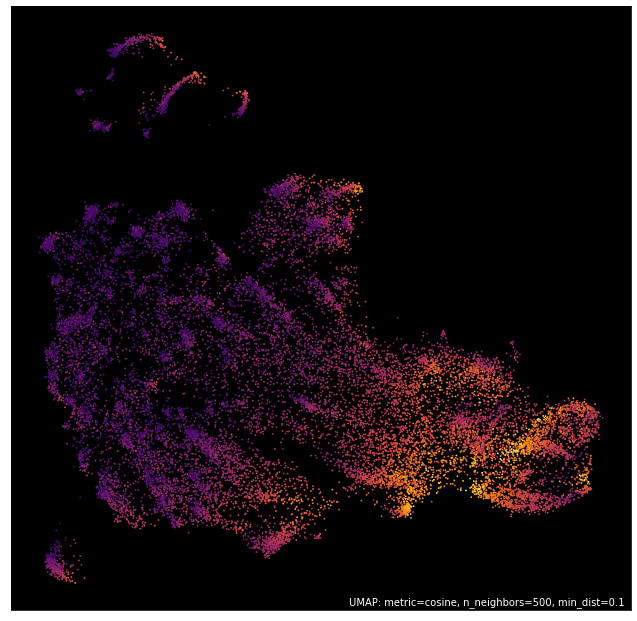

In [75]:
mapper = umap.UMAP(n_neighbors=500, metric='cosine').fit(master_games)
umap.plot.points(mapper, theme='inferno', values = master_games.GameWeight)

<AxesSubplot:>

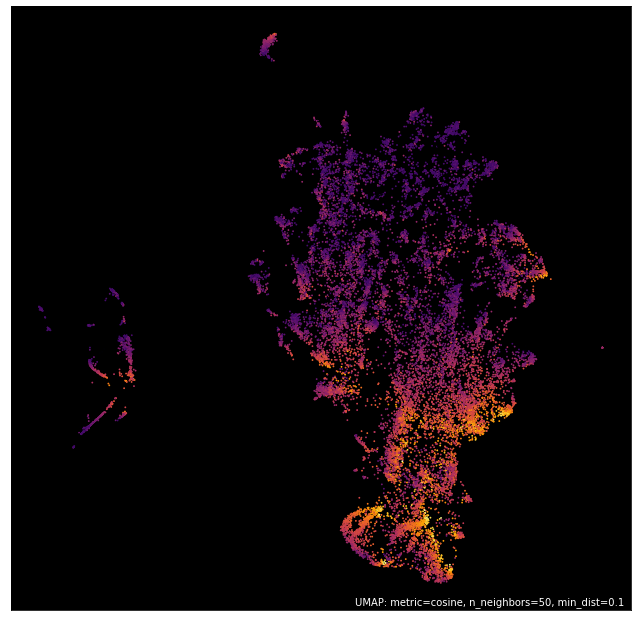

In [65]:
mapper = umap.UMAP(n_neighbors=50, metric='cosine').fit(master_games)
umap.plot.points(mapper, theme='inferno', values = master_games.GameWeight)

<AxesSubplot:>

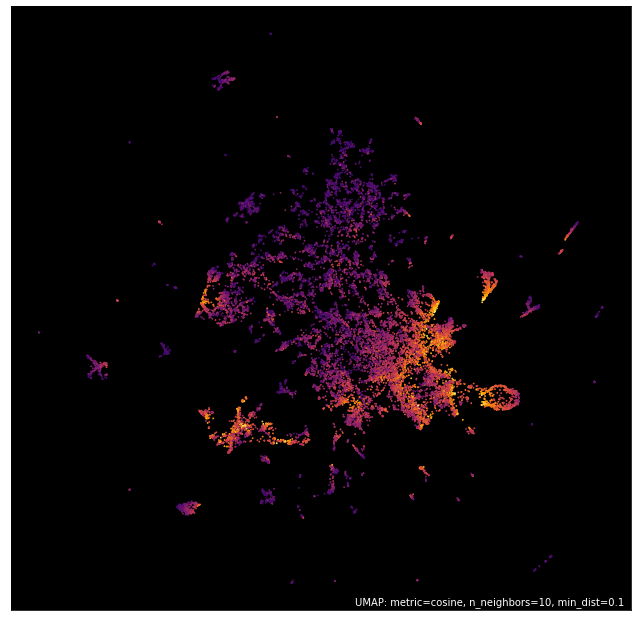

In [37]:
mapper = umap.UMAP(n_neighbors=10, metric='cosine').fit(master_games)
umap.plot.points(mapper, theme='inferno', values = master_games.GameWeight)

<AxesSubplot:>

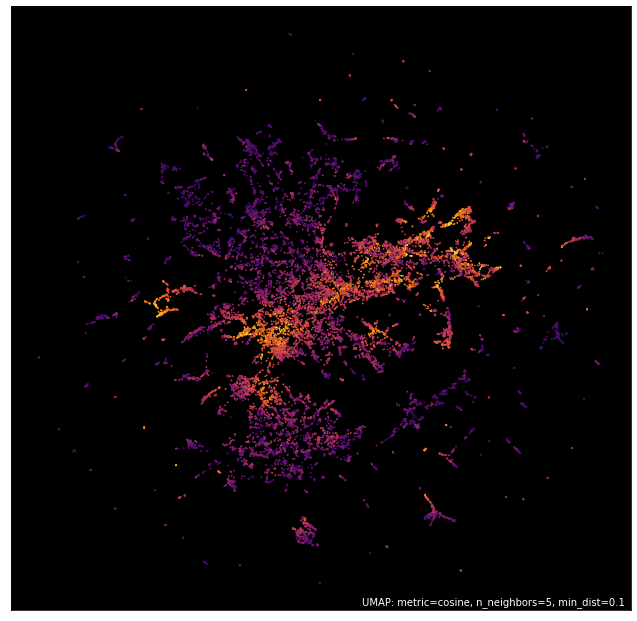

In [67]:
mapper = umap.UMAP(n_neighbors=5, metric='cosine').fit(master_games)
umap.plot.points(mapper, theme='inferno', values = master_games.GameWeight)

<AxesSubplot:>

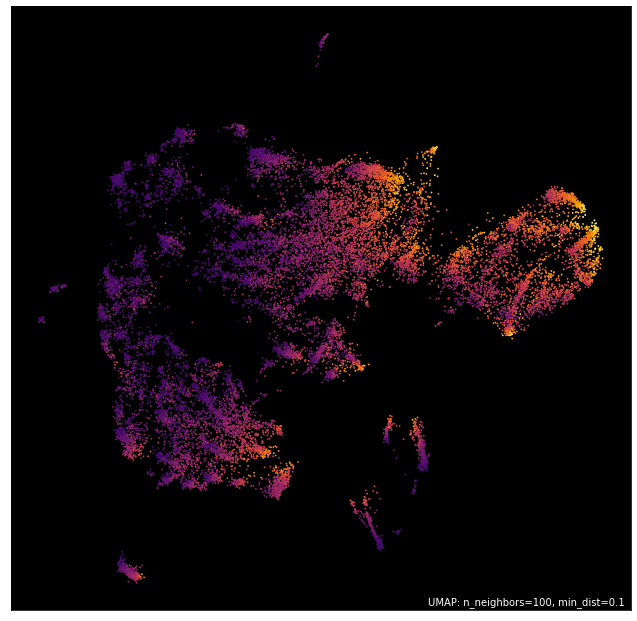

In [38]:
mapper = umap.UMAP(n_neighbors=100).fit(master_games)
umap.plot.points(mapper, theme='inferno', values = master_games.GameWeight)

<AxesSubplot:>

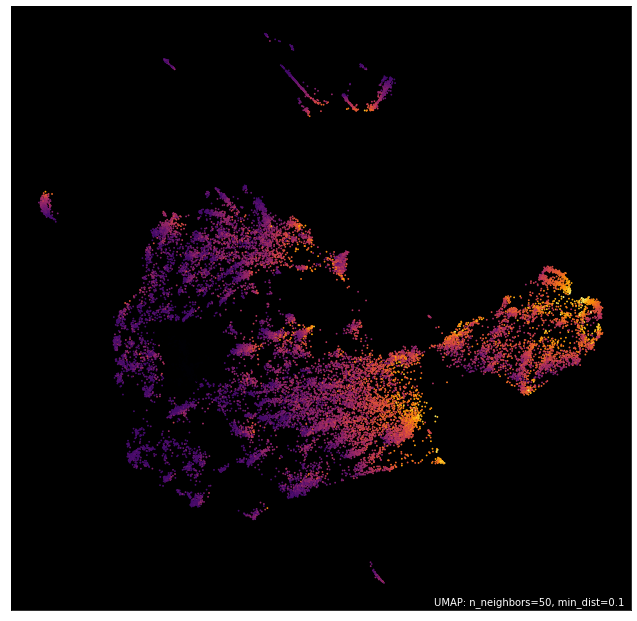

In [41]:
mapper = umap.UMAP(n_neighbors=50).fit(master_games)
umap.plot.points(mapper, theme='inferno', values = master_games.GameWeight)

<AxesSubplot:>

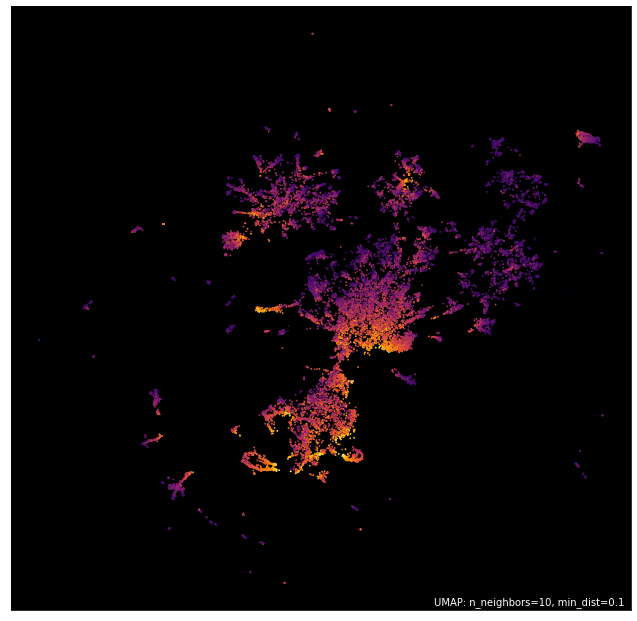

In [39]:
mapper = umap.UMAP(n_neighbors=10).fit(master_games)
umap.plot.points(mapper, theme='inferno', values = master_games.GameWeight)

<AxesSubplot:>

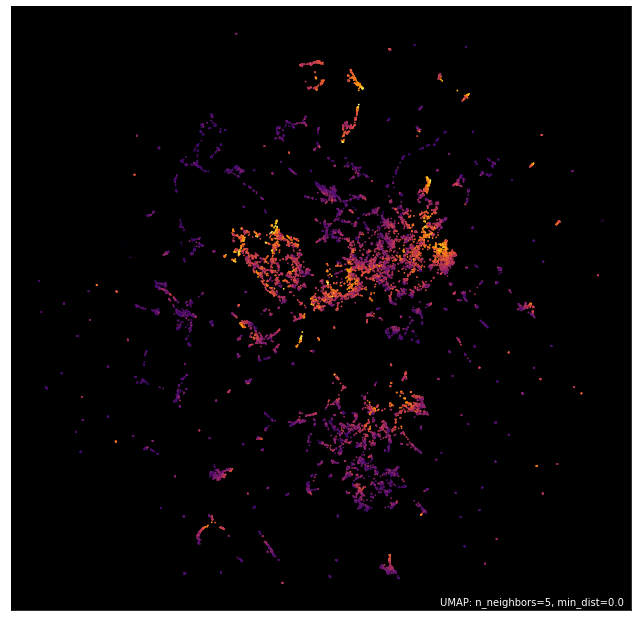

In [74]:
mapper = umap.UMAP(n_neighbors=5, min_dist=0.0).fit(master_games)
umap.plot.points(mapper, theme='inferno', values = master_games.GameWeight)

In [58]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(master_games)

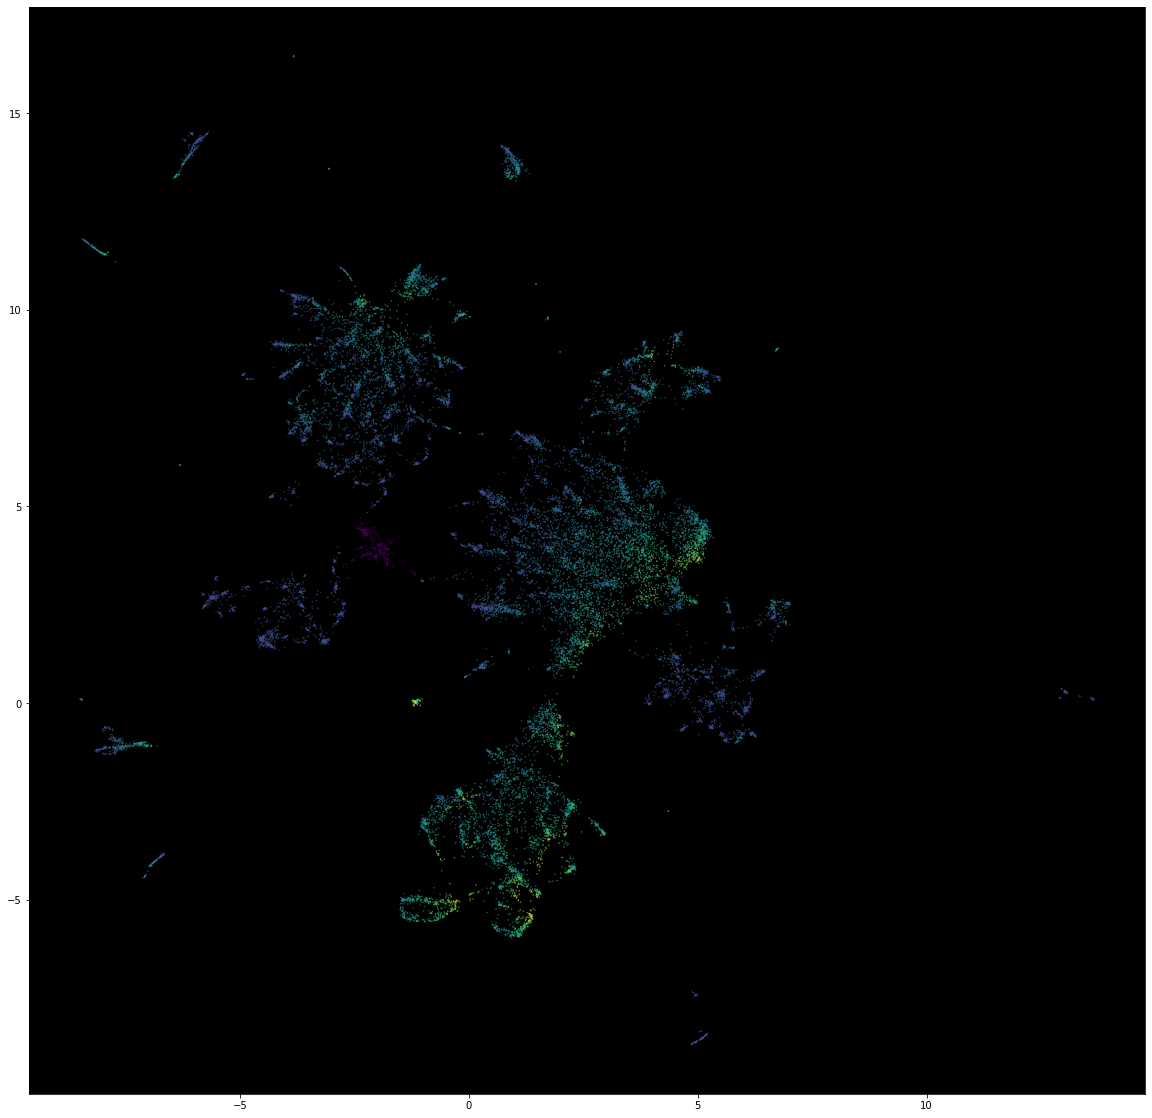

In [63]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_facecolor('black')
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=master_games.GameWeight, s=0.1, cmap='viridis');

In [71]:
kmeans_labels = cluster.KMeans(n_clusters=20).fit_predict(master_games)

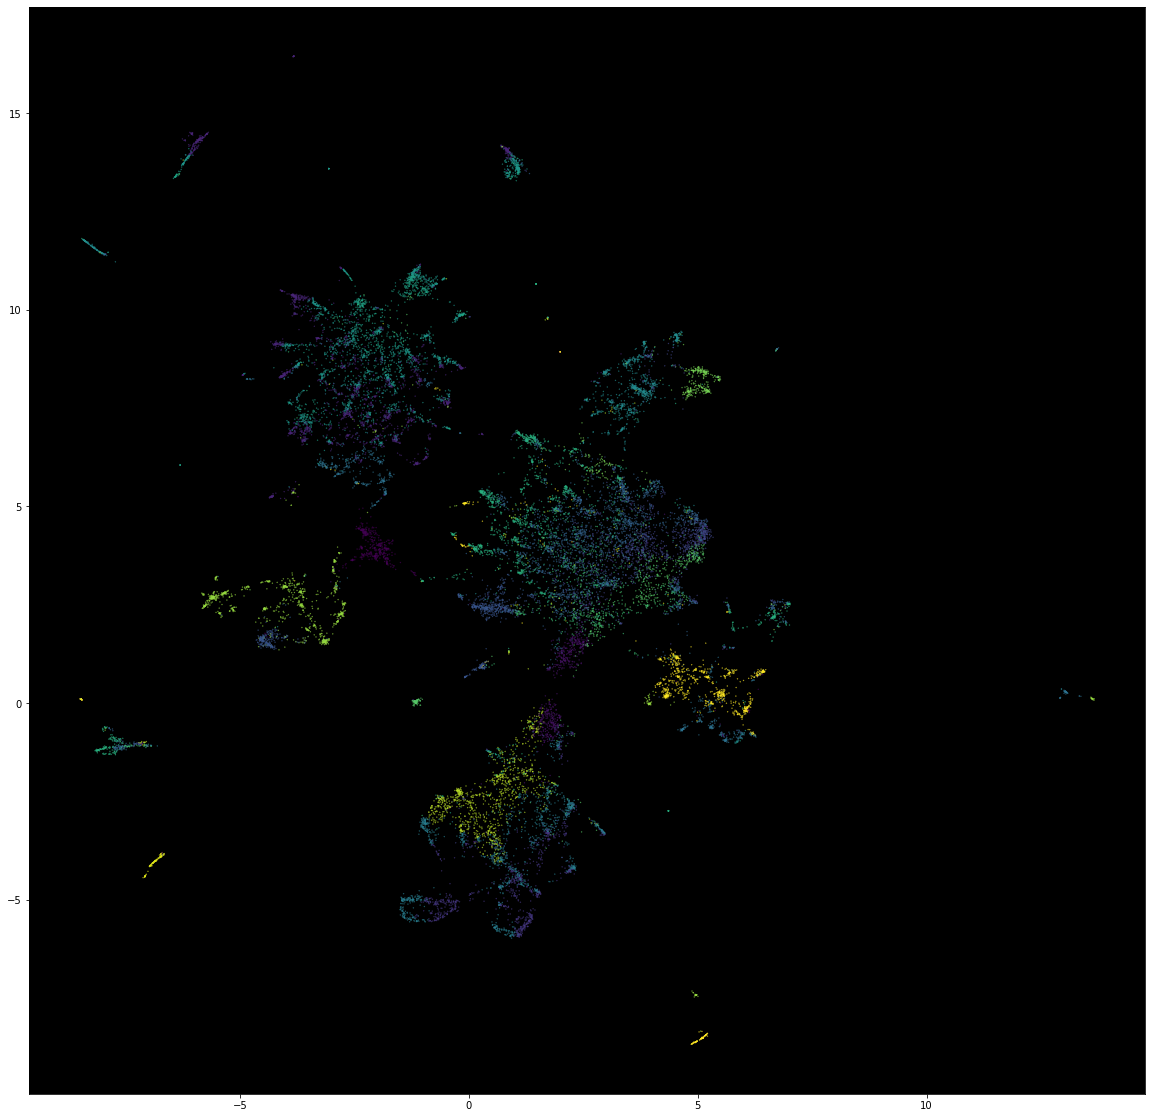

In [72]:
fig, ax = plt.subplots(figsize=(20,20))
ax.set_facecolor('black')
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='viridis');